In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

train_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=transform
)

val_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=transform
)

test_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=False,
    download=True,
    transform=transform
)

# Truco para poder realizar data augmentation de forma dinámica
train_cifar10, _ = torch.utils.data.random_split(train_cifar10, [45000, 5000], torch.Generator().manual_seed(42))
_, val_cifar10 = torch.utils.data.random_split(val_cifar10, [45000, 5000], torch.Generator().manual_seed(42))

100%|██████████| 170498071/170498071 [00:04<00:00, 42362681.52it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 3. Define the Model

class ShallowNet18(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        """
        Initialize an 18-layer shallow neural network.

        Args:
            input_channels (int): Number of input channels (e.g., 3 for RGB images).
            num_classes (int): Number of output classes.
        """
        super(ShallowNet18, self).__init__()
        layers = []
        hidden_size = 512  # You can adjust this as needed

        # Initial Convolutional Layer
        layers.append(nn.Conv2d(input_channels, 64, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())

        # Add 8 Convolutional Blocks (each block has Conv -> BatchNorm -> ReLU -> Dropout)
        for _ in range(8):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))

        # Pooling Layer
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Flatten Layer
        layers.append(nn.Flatten())

        # First Fully Connected Layer
        layers.append(nn.Linear(64 * 16 * 16, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))

        # Add 8 Fully Connected Layers (each layer has Linear -> ReLU -> Dropout)
        for _ in range(8):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))

        # Output Layer
        layers.append(nn.Linear(hidden_size, num_classes))

        # Combine all layers into a Sequential container
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [2]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [5]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)

        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = torchvision.transforms.Compose([
            original_transform,
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.Lambda(lambda x: x + torch.randn(3, 1, 1) * 0.05)
        ])

    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

Using train transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/30
Iteration 117 - Batch 117/704 - Train loss: 2.20605297108828, Train acc: 0.1496292372881356
Iteration 234 - Batch 234/704 - Train loss: 2.0991261076419914, Train acc: 0.16695478723404256
Iteration 351 - Batch 351/704 - Train loss: 2.0444802083075047, Train acc: 0.17449396306818182
Iteration 468 - Batch 468/704 - Train loss: 2.017197516427111, Train acc: 0.18070362473347548
Iteration 585 - Batch 585/704 - Train loss: 1.9962847511516089, Train acc: 0.18797994880546076
Iteration 702 - Batch 702/704 - Train loss: 1.9787119601563063, Train acc: 0.19221194879089615
Val loss: 1.8630826473236084, Val acc: 0.2276
Epoch 2/30
Iteration 821 - Batch 117/704 - Train loss: 1.8873788724511356, Train acc: 0.20921610169491525
Iteration 938 - Batch 23

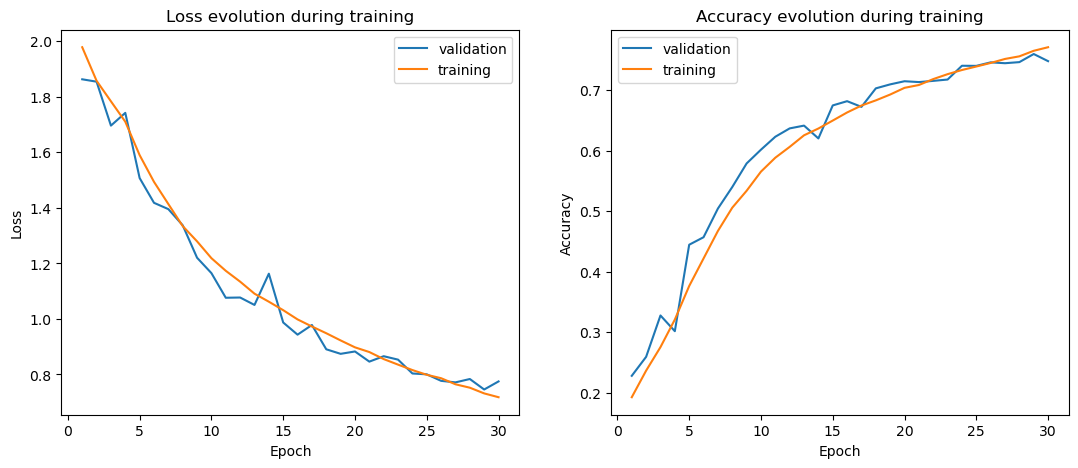

In [ ]:
lr = 5e-4
dropout_p = 0.5
batch_size = 64
criterion = nn.CrossEntropyLoss()

epochs = 30
model = ShallowNet18(input_channels=3, num_classes=10)

curves = train_model(
    model,
    train_cifar10,
    val_cifar10,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
)

show_curves(curves)

In [10]:
# 3. Define the Model

class ShallowNet18(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        """
        Initialize an 18-layer shallow neural network without dropout regularization.

        Args:
            input_channels (int): Number of input channels (e.g., 3 for RGB images).
            num_classes (int): Number of output classes.
        """
        super(ShallowNet18, self).__init__()
        layers = []
        hidden_size = 512  # You can adjust this as needed

        # Initial Convolutional Layer
        layers.append(nn.Conv2d(input_channels, 64, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())

        # Add 8 Convolutional Blocks (each block has Conv -> BatchNorm -> ReLU)
        for _ in range(8):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU())

        # Pooling Layer
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Flatten Layer
        layers.append(nn.Flatten())

        # First Fully Connected Layer
        layers.append(nn.Linear(64 * 16 * 16, hidden_size))
        layers.append(nn.ReLU())

        # Add 8 Fully Connected Layers (each layer has Linear -> ReLU)
        for _ in range(8):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Output Layer
        layers.append(nn.Linear(hidden_size, num_classes))

        # Combine all layers into a Sequential container
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [1]:
lr = 5e-4
dropout_p = 0.5
batch_size = 64
criterion = nn.CrossEntropyLoss()

epochs = 30
model = ShallowNet18()

curves = train_model(
    model,
    train_cifar10,
    val_cifar10,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
)

show_curves(curves)

NameError: name 'nn' is not defined